# TradingBot Klass README

## Introduktion
TradingBot är en Python-klass som erbjuder en rad funktioner för algoritmisk handel. Klassen använder IG:s handels-API för att interagera med marknader, söka efter tillgängliga instrument, hämta historisk prisdata och mycket mer. Den inkluderar också funktioner för att visualisera prisdata i form av ljusstake-diagram.

## Förutsättningar

- Python 3
- pipenv (Om du inte kör via colab eller Jupyter)
- Jupyter kernel (Om du inte kör via colab)

## Installation och Användning

Antingen kan du köra denna i Colab, eller om du vill köra i vs code some notebook måste du skaffa rätt kernel och sedan fixa en venv enligt instruktionena nedan.


Följ dessa steg för att installera alla nödvändiga beroenden:

### Steg 1: Installera pipenv om du inte redan har det
Öppna din terminal och kör följande kommando:

'pip install pipenv'

### Steg 2: Synka med existerande lock.filer
Öppna din terminal och kör följande kommando:

'pipenv sync'

Nu har du alla dependencies.








In [30]:
from trading_ig import IGService
import pandas as pd
import configparser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import mplfinance as mpf

# Typer av Ordrar i Handel

#### Market Order
En "Market Order" är en order att köpa eller sälja en tillgång omedelbart till det aktuella marknadspriset. 

#### Limit Order
En "Limit Order" är en order att köpa eller sälja en tillgång till ett specifikt pris eller bättre.

#### Stop Order
En "Stop Order" blir en "Market Order" när ett visst pris nås.

#### Stop-Limit Order
En "Stop-Limit Order" blir en "Limit Order" när ett specifikt stopppris nås.

#### Trailing Stop Order
En "Trailing Stop Order" sätter ett stopppris på en viss avstånd från marknadspriset.

#### Good Till Cancelled (GTC)
En "Good Till Cancelled"-order förblir aktiv tills den utförs eller annulleras.

#### Day Order
En "Day Order" är giltig endast under den aktuella handelsdagen.

#### Immediate or Cancel (IOC)
En "Immediate or Cancel"-order måste utföras omedelbart och eventuella ofyllda delar annulleras.

#### Fill or Kill (FOK)
En "Fill or Kill"-order måste utföras omedelbart och i sin helhet.




name: USD/SEK epic: CS.D.USDSEK.CFD.IP


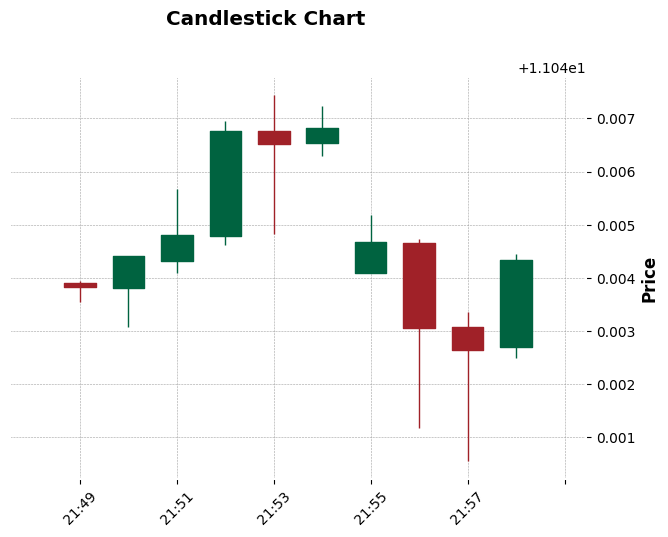

In [31]:
class TradingBot:
    def __init__(self, config_file_path):
        self.config_file_path = config_file_path
        self.api_key = self.read_config('Credentials', 'apikey')
        self.username = self.read_config('Credentials', 'username')
        self.password = self.read_config('Credentials', 'password')
        self.acc_type = 'DEMO'
        self.ig_service = IGService(self.username, self.password, self.api_key, self.acc_type)
        self.ig_service.create_session()
        self.order_executor = OrderExecutor(self)


    def read_config(self, section, key):
        config = configparser.ConfigParser()
        try:
            config.read(self.config_file_path)
            return config.get(section, key)
        except Exception as e:
            print(f"Ett fel uppstod när konfigurationsfilen skulle läsas: {e}")
            return None

    def fetch_data(self, epic, freq='1Min', num_points=10):
        response = self.ig_service.fetch_historical_prices_by_epic_and_num_points(epic, freq, num_points)
        df = pd.DataFrame(response['prices'])
        return df

    def search_markets(self, search_term):
        try:
            response = self.ig_service.search_markets(search_term)
            return self.parse_response_to_tuples(pd.DataFrame(response))
        except Exception as e:
            print(f"Ett fel uppstod när marknader skulle sökas: {e}")
            return None

    def parse_response_to_tuples(self, response_df):
        return list(response_df[['epic', 'instrumentName']].itertuples(index=False, name=None))

    def plot_candlestick(self, df):
        try:
            # Omvandla din DataFrame till det format mplfinance förväntar sig.
            # Antag att 'df' innehåller 'bid' data
            df = df['bid'].copy()
            df.columns = ['Open', 'High', 'Low', 'Close']
            
            # Skapa candlestick-diagrammet
            mpf.plot(df, type='candle', style='charles', title='Candlestick Chart', ylabel='Price')
        except Exception as e:
            print(f"An error occurred while plotting the candlestick chart: {e}")


    def send_order(self, order_details):
        print(f"Skickar order: {order_details}")
        # Kod för att faktiskt skicka order skulle gå här, t.ex. en API-anrop.




#Användning
config_file_path = r"C:\Dev\config\aktiebot.cfg"
bot = TradingBot(config_file_path)
#print(bot.fetch_data('CS.D.EURUSD.MINI.IP'))
epic_list = bot.search_markets('USD/SEK')
print(f"name: {epic_list[0][1]} epic: {epic_list[0][0]}")
df = bot.fetch_data(epic_list[0][0], freq='1Min', num_points=10)
bot.plot_candlestick(df)



In [32]:
class OrderExecutor:
    def __init__(self, trading_bot):
        self.trading_bot = trading_bot
        
    def execute_market_order(self, asset, quantity):
        order_details = {
            'type': 'Market',
            'asset': asset,
            'quantity': quantity
        }
        self.trading_bot.send_order(order_details)
        
    def execute_limit_order(self, asset, quantity, price):
        order_details = {
            'type': 'Limit',
            'asset': asset,
            'quantity': quantity,
            'price': price
        }
        self.trading_bot.send_order(order_details)
        
    def execute_stop_order(self, asset, quantity, stop_price):
        order_details = {
            'type': 'Stop',
            'asset': asset,
            'quantity': quantity,
            'stop_price': stop_price
        }
        self.trading_bot.send_order(order_details)
        
    def execute_stop_limit_order(self, asset, quantity, stop_price, limit_price):
        order_details = {
            'type': 'Stop Limit',
            'asset': asset,
            'quantity': quantity,
            'stop_price': stop_price,
            'limit_price': limit_price
        }
        self.trading_bot.send_order(order_details)